
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Synths Demo

This notebook demonstrates the use of Synthesizer `Processors()`. 


## Additive 

Additive synthesis models a sound as a linear combination of sinusoids. While each sine wave (oscillator) is quite simple, the combination of a bank of oscillators can genereate an expressive range of sounds. However, the true amplitude and frequency of each oscillator is a complicated function for natural sounds. Thus, additive synthesis often sounds unrealistic when tuned by hand. DDSP overcomes these challenges by allowing these parameters to be tuned with autodifferention and neural networks.

## FilteredNoise

While additive synthesis can model most harmonic sounds, it has no way to produce stochastic signals. The FilteredNoise synthesizer takes white noise and filters it with a time-varying finite impulse response filter, whose transfer function is specified each frame by a neural network


# Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import os
import time

from colabtools import sound
import gin
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_datasets as tfds
import functools

import ddsp 

tfkl = tf.keras.layers
sess = tf.compat.v1.InteractiveSession()

# Helper Functions 
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)

def f32(tensor):
  return tf.convert_to_tensor(tensor, dtype=tf.float32)

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  logmag = ddsp.spectral_ops.calc_logmag(f32(audio), size=size).eval()
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])



#  `Additive()`

We covered the harmonic `Additive()` synthesizer in `0_processors.ipynb`, but just for fun, let's run another example where we tweak some of the controls...

In [0]:
## Just some weird control envelopes...

# Amplitude [batch, n_frames, 1].
amps = np.ones([n_frames]) * -5.0
amps[:50] +=  np.linspace(0, 7.0, 50)
amps[50:200] += 7.0
amps[200:900] += (7.0 - np.linspace(0.0, 7.0, 700))
amps *= np.abs(np.cos(np.linspace(0, 2*np.pi * 10.0, n_frames)))
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  harmonic_distribution[:, i] *= 5.0 * np.abs(np.cos(np.linspace(0, 2*np.pi * 0.1 * i, n_frames)))
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.ones([n_frames]) * 200.0
f0_hz[:100] *= np.linspace(2, 1, 100)**2
f0_hz[200:1000] += 20 * np.sin(np.linspace(0, 8.0, 800) * 2 * np.pi * np.linspace(0, 1.0, 800))  * np.linspace(0, 1.0, 800)
f0_hz = f0_hz[np.newaxis, :, np.newaxis]

# Get valid controls
controls = additive_synth.get_controls(f32(amps), f32(harmonic_distribution), f32(f0_hz))

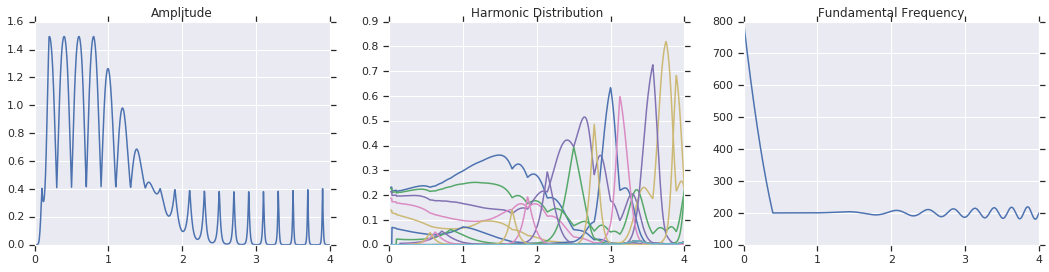

In [0]:
# Plot!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

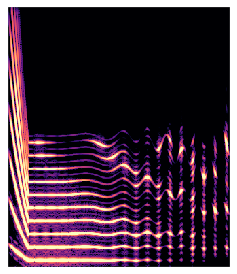

In [0]:
audio = additive_synth.get_signal(**controls)
audio_np = audio.eval()[0, :]

play(audio_np)
specplot(audio_np)

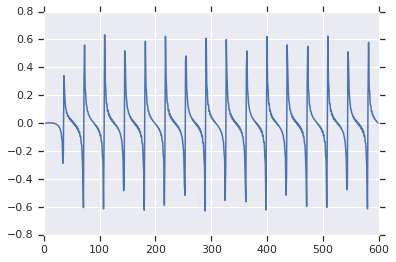

In [0]:
# Note, the amplitude envelope upsamples with overlapping Hann windows.
# This smooths temporal discontinuities, but limits the attack responsiveness.
plt.plot(audio_np[:600])